In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# A short tutorial on the mean square displacement

## The raw mathematical definition

The mean square displacement for a time difference $\Delta t$ is computed as the squared distance between the position of the particle at time $t$ and its position at time $t + \Delta t$ averaged over each successive time $t$:


$$
\mbox{MSD}(\Delta t) =  \frac{\sum_0^{T - \Delta t} ||\mathbf{r}(t + \Delta t)  - \mathbf{r}(t)||^2}{(T - \Delta t) / \delta t} = \frac{d_{t, t+\Delta t}}{(T - \Delta t) / \delta t}
$$


Here the vector $\mathbf{r}(t)$ denotes the position of the particle at time $t$.

So for a given trajectory we'll mesure the mean square displacement for a delay of 10s ($\Delta t = 10s$) by computing the distance between the particle's position at time $0 s$ and it's position at time $9 s$, then between $1 s$ and $10 s$, and so on, square all those distances, and take the mean of those values.

![Computing mean square displacement from positions](msd_positions.svg)

The value of the MSD for a 10 seconds delay is the mean of the squares of the distances reprensented by the arrows above

### Why bother?

The mean square displacement is usefull as it allows to measure the diffusion coefficient of a particle in case the movement is random. When the movement is random, the MSD grows linearly with the delay, and when it's linear, it grows like the square of the delay. We'll see why..

## Let's create two trajectories, one random and one linear, in 2D

In [2]:
## Number of points in the trajectories
n_points = 1000

## Time step between two points
t_step = 1
## Scale of the random movement (standard diviation)
scale = 1.

## 
xy_random = np.random.normal(scale=scale, size=(n_points, 2)).cumsum(axis=0)
xy_random = pd.DataFrame(data=xy_random, 
                         index=pd.Index(np.arange(n_points), name='t_stamp'), columns=['x', 'y'])
xy_random['t'] = np.arange(n_points) * t_step

xy_linear = np.vstack([np.arange(n_points), np.arange(n_points)]).T
xy_linear = pd.DataFrame(data=xy_linear, 
                         index=pd.Index(np.arange(n_points), name='t_stamp'), columns=['x', 'y'])
xy_linear['t'] = np.arange(n_points) * t_step


### $x$ vs $y$ plots of the two trajectories

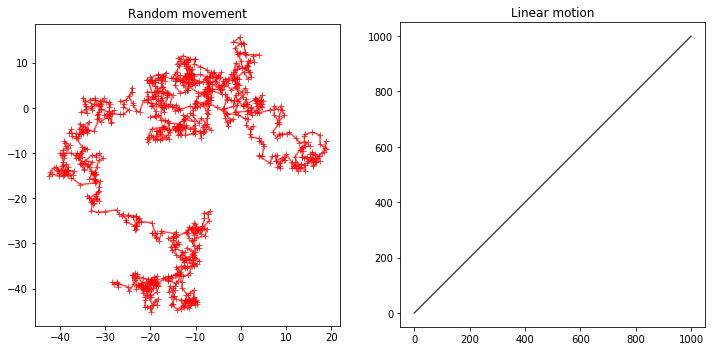

In [3]:
fig, (ax_rnd, ax_lin) = plt.subplots(1, 2, figsize=(12,6))

ax_rnd.plot(xy_random.x, xy_random.y, '-r+', alpha=0.7)
ax_rnd.set_aspect('equal')
ax_rnd.set_title('Random movement')

ax_lin.plot(xy_linear.x, xy_linear.y, '-k', alpha=0.7)
ax_lin.set_aspect('equal')

ax_lin.set_title('Linear motion');

### Point to point distance for a given delay

In [4]:
delay = 4

#the number of data points corresponding to the delay
shift = np.int(delay / t_step)

### The idea here is just to shif the data and take the difference
pos_diff_rnd = xy_random - xy_random.shift(-shift)
pos_diff_lin = xy_linear - xy_linear.shift(-shift)

### The square displacement is the sum of the squares of each coordinates
sq_dist_rnd = np.square(pos_diff_rnd[['x', 'y']]).sum(axis=1, skipna=False)
sq_dist_lin = np.square(pos_diff_lin[['x', 'y']]).sum(axis=1, skipna=False)


### Print the last points of this squared distance
print('Square distance between points {} s appart (last {} points):'.format(delay, shift+2))
print(sq_dist_rnd.tail(shift+2))

Square distance between points 4 s appart (last 6 points):
t_stamp
994    0.618883
995    2.937484
996         NaN
997         NaN
998         NaN
999         NaN
dtype: float64


Note that the difference is not defined for the last points, because there is no point to measure a distance with.
This is an important aspect to keep in mind with MSD computations:
<hr>
When the delay gets bigger, there is less and less data to compute the MSD and do the average, so **the mean square displacement 
for big delays is meaningless for single trajectories**.
<hr>

In [5]:
## MSD for the given delay:
msd_rnd = sq_dist_rnd.dropna().mean()
msd_lin = sq_dist_lin.dropna().mean()

print('Mean square displacements for delay {}:'.format(delay))
print('\t Random motion: {0:.3f}'.format(msd_rnd))
print('\t Linear motion: {0:.3f}'.format(msd_lin))


Mean square displacements for delay 4:
	 Random motion: 8.133
	 Linear motion: 32.000


In [6]:
### Now let's code a function that will do this for all the possible delays:

def compute_msd(trajectory, t_step, coords=['x', 'y']):
    
    delays = trajectory.t.copy()
    shifts = np.floor(delays/t_step).astype(np.int)
    msds = np.zeros(shifts.size)
    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1, skipna=False)
        msds[i] = sqdist.mean()
    return delays, msds

In [7]:
delays, msds_rnd = compute_msd(xy_random, t_step=t_step)
delays, msds_lin = compute_msd(xy_linear, t_step=t_step)


### Plot of the mean square displacement as a function of the delay

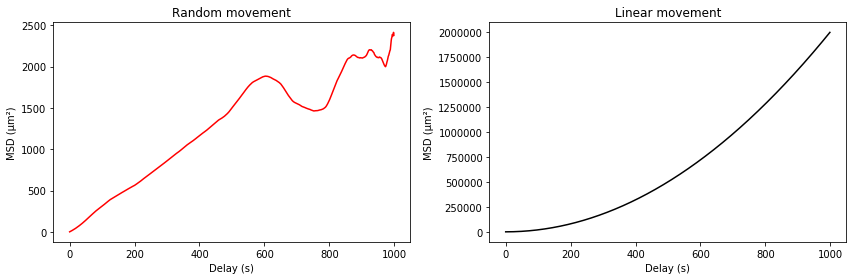

In [8]:
fig, (ax_rnd, ax_lin) = plt.subplots(1, 2, figsize=(12, 4))
ax_rnd.plot(delays, msds_rnd, '-r')
ax_rnd.set_title("Random movement")
ax_rnd.set_xlabel('Delay (s)')
ax_rnd.set_ylabel('MSD (µm²)')

ax_lin.plot(delays, msds_lin, '-k')
ax_lin.set_title("Linear movement")
ax_lin.set_xlabel('Delay (s)')
ax_lin.set_ylabel('MSD (µm²)')
fig.tight_layout()


What we see on the graphs above is that indead - at the begining - the MSD for the random motion varies lineary with the delay, while the linear motion's MSD behaves like an hyperbole. We could have easily guessed the later behavior:

A linear displacement means the distance from one point to an other is proportional to the delay between those points: $d_{t, t+\Delta t} = a \Delta t$. As this is independant of $t$, the average will be simply $a \Delta t$, and the average of the square, the MDS, $a^2  \Delta t^2$

## Relation with the diffusion coefficient

TODO...